# Face Mask Detection

In [63]:
# load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET
import os
import random
from matplotlib import patches
from sklearn.model_selection import train_test_split
import shutil
import glob

In [64]:
# load YOLO
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.136 🚀 Python-3.10.11 torch-2.0.1 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 8.0 GB RAM, 182.7/460.4 GB disk)


## Directory

In [27]:
directory = "/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/Data"
image_directory = directory + "/images"
annotation_directory = directory + "/annotations"
annotations = list(Path(annotation_directory).glob(r'**/*{}'.format('xml')))

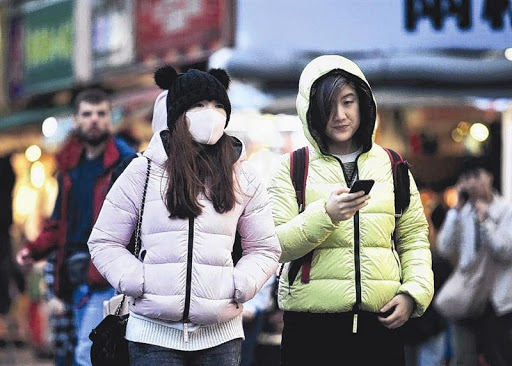

In [28]:
Image.open(image_directory + "/maksssksksss0.png")

In [29]:
with open(annotation_directory + '/maksssksksss0.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

## Data Preparation

In [30]:
class_id = {
    "with_mask" : 0,
    "mask_weared_incorrect" : 1,
    "without_mask" : 2
}

data_dict = {
    'filename': [],
    'label': [],
    'class_id': [],
    'width': [],
    'height': [],
    'bboxes': []
}
for annotation_path in annotations:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text
        
        bbox = []
        # bndbox has xmin, ymin, xmax, ymax
        bndbox_tree = obj.find('bndbox')
        bbox.append(int(bndbox_tree.find('xmin').text))
        bbox.append(int(bndbox_tree.find('ymin').text))
        bbox.append(int(bndbox_tree.find('xmax').text))
        bbox.append(int(bndbox_tree.find('ymax').text))
        size = root.find('size')
        
        data_dict['filename'].append(filename)
        data_dict['width'].append(int(size.find('width').text))
        data_dict['height'].append(int(size.find('height').text))
        data_dict['label'].append(label)
        data_dict['class_id'].append(class_id[label])
        data_dict['bboxes'].append(bbox)

In [31]:
df_data = pd.DataFrame(data_dict)
df_data.head()

filename                  label  class_id  width  height  \
0  maksssksksss299.png           without_mask         2    301     400   
1  maksssksksss528.png           without_mask         2    301     400   
2  maksssksksss272.png  mask_weared_incorrect         1    275     400   
3  maksssksksss514.png              with_mask         0    400     267   
4  maksssksksss514.png              with_mask         0    400     267   

                bboxes  
0  [62, 194, 160, 320]  
1  [43, 169, 149, 308]  
2  [48, 107, 218, 304]  
3     [28, 78, 43, 99]  
4   [160, 66, 176, 83]

In [32]:
df_data.isna().sum()

filename    0
label       0
class_id    0
width       0
height      0
bboxes      0
dtype: int64

In [33]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   class_id  4072 non-null   int64 
 3   width     4072 non-null   int64 
 4   height    4072 non-null   int64 
 5   bboxes    4072 non-null   object
dtypes: int64(3), object(3)
memory usage: 191.0+ KB


In [34]:
print(f"Total 'without_mask' labels: {sum(df_data.label == 'without_mask')}")
print(f"Total 'mask_weared_incorrect' labels: {sum(df_data.label == 'mask_weared_incorrect')}")
print(f"Total 'with_mask' labels: {sum(df_data.label == 'with_mask')}")

Total 'without_mask' labels: 717
Total 'mask_weared_incorrect' labels: 123
Total 'with_mask' labels: 3232


## Visualisation

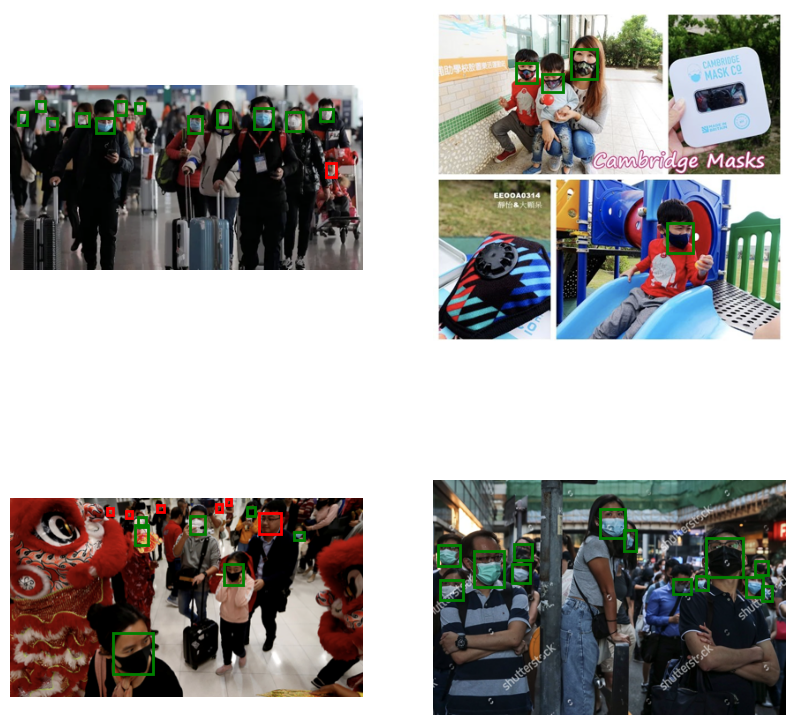

In [41]:
def show_random_images_with_bbox(df):
    all_images = os.listdir(image_directory)
    random_image_filename = random.sample(all_images, 4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, filename in enumerate(random_image_filename):
        selected_df = df[df['filename'] == filename]
        
        image = Image.open(image_directory + '/' + filename)
        
        ax.flat[i].imshow(image)
        ax.flat[i].axis(False)
        
        image_bboxes = []
        for df_index in range(0, len(selected_df)):
            color = "g"
            if selected_df.iloc[df_index].class_id == 1: color = "y"
            elif selected_df.iloc[df_index].class_id == 2: color = "r"
            
            x_min, y_min, x_max, y_max = selected_df.iloc[df_index].bboxes
            
            rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min, 
                             linewidth=2, edgecolor=color, facecolor="none")
            ax.flat[i].add_patch(rect)
            
show_random_images_with_bbox(df_data)

In [42]:
# convert bbox into YOLO format
def pascal_voc_to_yolo_bbox(bbox_array, w, h):
    x_min, y_min, x_max, y_max = bbox_array
    
    x_center = ((x_max + x_min) / 2) / w
    y_center = ((y_max + y_min) / 2) / h
    
    width = (x_max - x_min) / w
    height = (y_max - y_min) / h
    
    return [x_center, y_center, width, height]

## Train Dev Test Split

In [59]:
# create new directories for data

train_path = "/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/datasets/train"
valid_path = "/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/datasets/valid"
test_path = "/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/datasets/test"

os.mkdir("/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/datasets")
os.mkdir(train_path)
os.mkdir(valid_path)
os.mkdir(test_path)

In [60]:
train, test = train_test_split(df_data.filename.unique(), test_size=0.2, random_state=1)
train, valid = train_test_split(train, test_size=0.15, random_state=1)

In [61]:
def copy_image_file(image_items, folder_name):
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name):
    for image in image_items:
        fileName = Path(image).stem
        df = df_data[df_data['filename'] == image]
        with open(folder_name + "/" + fileName +'.txt', 'w') as f:
            for i in range(0, len(df)):
                bbox = pascal_voc_to_yolo_bbox(df.iloc[i]['bboxes'], df.iloc[i]['width'], df.iloc[i]['height'])
                bbox_text = " ".join(map(str, bbox))
                txt = str(df.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df) - 1:
                    f.write("\n")

copy_image_file(train, train_path)
copy_image_file(valid, valid_path)
copy_image_file(test, test_path)

create_label_file(train, train_path)
create_label_file(valid, valid_path)
create_label_file(test, test_path)

In [56]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(glob.glob(filepath + '/*.png', recursive = True))} images in '{dirpath}'.")
    
walk_through_dir(train_path)
walk_through_dir(valid_path)  
walk_through_dir(test_path)  

There are 0 directories and 579 images in '/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/Data/Split/train'.
There are 0 directories and 103 images in '/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/Data/Split/valid'.
There are 0 directories and 171 images in '/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/Data/Split/test'.


## YAML file

In [57]:
classes = list(df_data.label.unique())
class_count = len(classes)
facemask_yaml = f"""
    train: train
    val: valid
    test: test
    nc: {class_count}
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    """

with open('facemask.yaml', 'w') as f:
    f.write(facemask_yaml)
    
%cat facemask.yaml


    train: train
    val: valid
    test: test
    nc: 3
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    

## Train YOLO Model

In [65]:
model = YOLO("yolov8n.pt") 
model.train(data="facemask.yaml", epochs=50)

New https://pypi.org/project/ultralytics/8.0.138 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.136 🚀 Python-3.10.11 torch-2.0.1 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=facemask.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, fo

In [66]:
model.val(data="facemask.yaml")

Ultralytics YOLOv8.0.136 🚀 Python-3.10.11 torch-2.0.1 CPU (Apple M2)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients
val: Scanning /Users/nathan/Documents/Portfolio/Projects/Face Mask Detec
                 Class     Images  Instances      Box(P          R      
                   all        103        514      0.947      0.816      0.856      0.604
             with_mask        103        425      0.964      0.925      0.965      0.687
 mask_weared_incorrect        103         10      0.997        0.7      0.738      0.539
          without_mask        103         79      0.881      0.823      0.866      0.585
Speed: 0.6ms preprocess, 106.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x2b063f430>
fitness: 0.6291922679543926
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.68724,      0.5394,     0.58525])
names: {0: 'with_mask', 1: 'mask_weared_incorrect', 2: 'without_mask'}
plot: True
results_dict: {'metrics/precision(B)': 0.9471429508062554, 'metrics/recall(B)': 0.8158302308265077, 'metrics/mAP50(B)': 0.8562616136858878, 'metrics/mAP50-95(B)': 0.6039623406508932, 'fitness': 0.6291922679543926}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 0.6230780221883533, 'inference': 106.50639626586322, 'loss': 8.10160220248028e-05, 'postprocess': 0.21964600942667248}

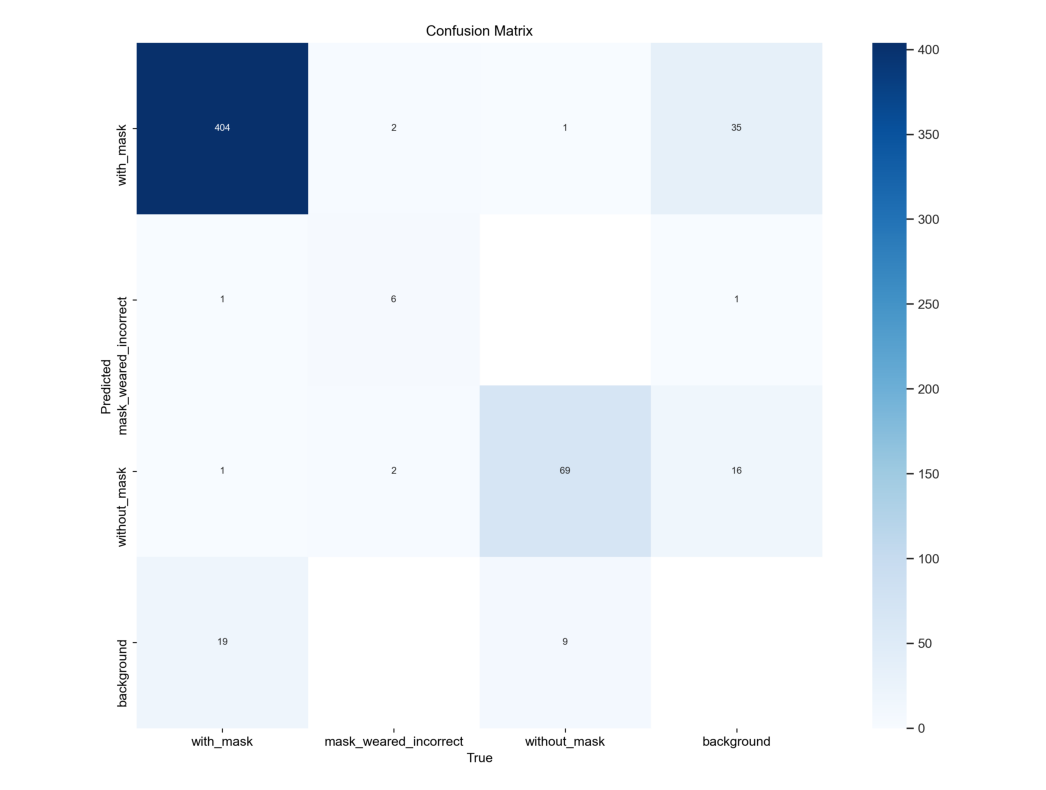

In [69]:
#saves in train3
confusion_matrix = Image.open("/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/runs/detect/train3/confusion_matrix.png")
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

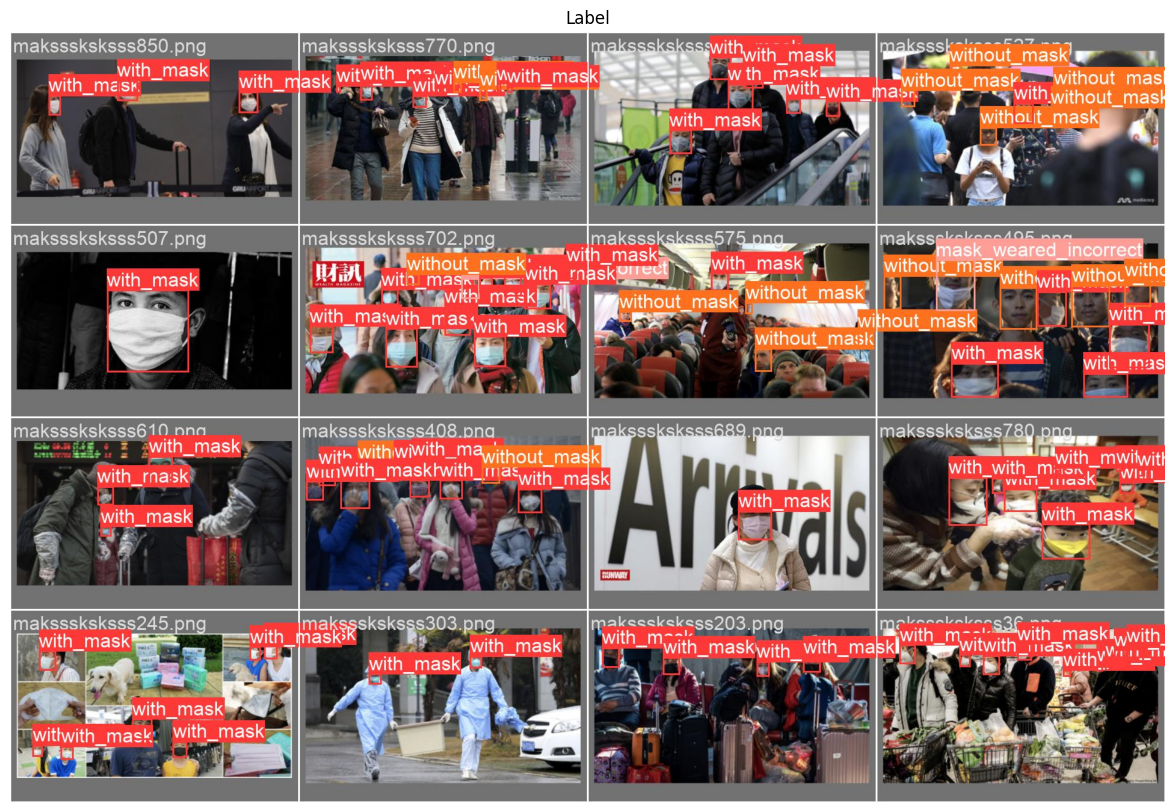

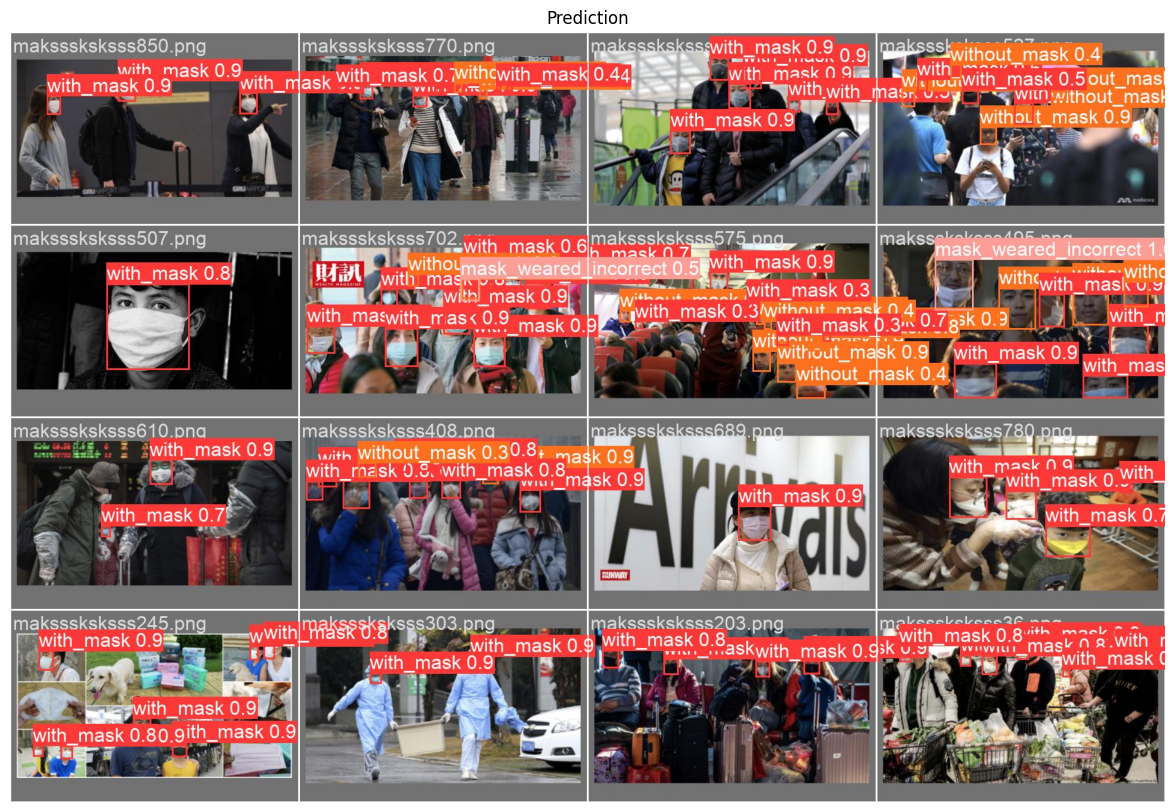

In [70]:
val_label = Image.open("/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/runs/detect/train3/val_batch0_labels.jpg")
val_pred = Image.open("/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/runs/detect/train3/val_batch0_pred.jpg")

plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

## Predict

In [71]:
model = YOLO(model="/Users/nathan/Documents/Portfolio/Projects/Face Mask Detection/runs/detect/train3/weights/best.pt")